In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
from pathlib import Path
import time
import warnings
warnings.filterwarnings(action='ignore')
from collections import defaultdict
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(devices))

Num GPUs Available:  0


## Data load

In [ ]:
os.chdir('/content/drive/MyDrive/Colab Notebooks/Place')
dir = os.getcwd()
dir = Path(dir)

In [ ]:
train_files = dir.glob('**/*.jpg')
train_list = list(train_files)
train_list[:5]

[PosixPath('/content/drive/MyDrive/Colab Notebooks/Place/waterpark/waterpark1.jpg'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/Place/waterpark/waterpark2.jpg'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/Place/waterpark/waterpark3.jpg'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/Place/waterpark/waterpark4.jpg'),
 PosixPath('/content/drive/MyDrive/Colab Notebooks/Place/waterpark/waterpark5.jpg')]

In [ ]:
train_data = defaultdict(list)
for p in train_list:
  train_data[p.parent.name].append(p)

In [ ]:
place = []
for file in train_list:
  place.append(file.parent.name)

In [ ]:
place[:5]

['waterpark', 'waterpark', 'waterpark', 'waterpark', 'waterpark']

In [ ]:
tr_list = []
for file in train_list:
    tr_list.append(str(file))

In [ ]:
tr_list[:3]

['/content/drive/MyDrive/Colab Notebooks/Place/waterpark/waterpark1.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Place/waterpark/waterpark2.jpg',
 '/content/drive/MyDrive/Colab Notebooks/Place/waterpark/waterpark3.jpg']

In [ ]:
dic = {'file_path':tr_list, 'place':place}
data = pd.DataFrame(dic)
data.head()

,file_path,place
0,/content/drive/MyDrive/Colab Notebooks/Place/w...,waterpark
1,/content/drive/MyDrive/Colab Notebooks/Place/w...,waterpark
2,/content/drive/MyDrive/Colab Notebooks/Place/w...,waterpark
3,/content/drive/MyDrive/Colab Notebooks/Place/w...,waterpark
4,/content/drive/MyDrive/Colab Notebooks/Place/w...,waterpark


In [ ]:
classes = list(data['place'].unique())
classes = sorted(classes)
classes

['baseballpark',
 'beach',
 'campsite',
 'campus',
 'city',
 'coffee_shop_food',
 'fairway',
 'festival',
 'field',
 'garden_forest',
 'mountain',
 'parkinglot',
 'river',
 'ski_slope',
 'supermarket',
 'themepark',
 'waterpark',
 'zoo']

In [ ]:
n_feat = data['place'].nunique()
print(n_feat)

18


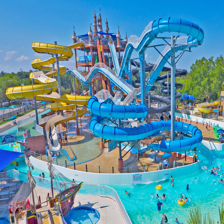

In [ ]:
img = Image.open(data.iloc[0,0])
img = img.resize((224, 224))
display(img)

## Data preprcess

In [ ]:
# split train / valid / test data

In [ ]:
train, test = train_test_split(data, test_size=0.2, shuffle=True, stratify=data['place'], random_state=123)

In [ ]:
len(data)

9326

In [ ]:
len(train)

7460

In [ ]:
train, valid = train_test_split(train, test_size=0.2, shuffle=True, stratify=train['place'], random_state=123)

In [ ]:
len(train)

5968

In [ ]:
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

In [ ]:
train.head()

,file_path,place
0,/content/drive/MyDrive/Colab Notebooks/Place/m...,mountain
1,/content/drive/MyDrive/Colab Notebooks/Place/f...,field
2,/content/drive/MyDrive/Colab Notebooks/Place/c...,city
3,/content/drive/MyDrive/Colab Notebooks/Place/w...,waterpark
4,/content/drive/MyDrive/Colab Notebooks/Place/c...,coffee_shop_food


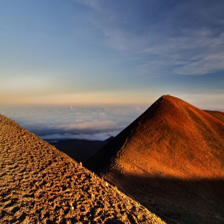

place : mountain


In [ ]:
img = Image.open(train.iloc[0,0])
img = img.resize((224, 224))
display(img)
print('place :', train.iloc[0,1])

In [ ]:
# data augmentation: make the image data generator
train_datagen = image.ImageDataGenerator(rescale=1./255,
                                       rotation_range=90,
                                       shear_range=0.3,
                                       zoom_range=[0.5, 1.0],
                                       vertical_flip=True,
                                       horizontal_flip=True)

test_datagen = image.ImageDataGenerator(rescale=1./255)

In [ ]:
batch_size = 64

In [ ]:
# generate datasets : train / valid / test

In [ ]:
tr_set = train_datagen.flow_from_dataframe(train,
                                           x_col='file_path',
                                           y_col='place',
                                           classes=classes,
                                           target_size=(224, 224),
                                           batch_size=batch_size,
                                           class_mode='categorical',
                                           shuffle=True)

Found 5968 validated image filenames belonging to 18 classes.


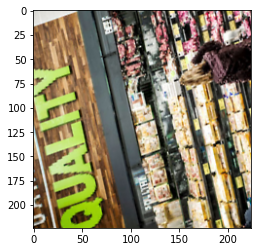

In [ ]:
for batch in tr_set:
    x, y = batch
    plt.imshow(x[0])
    break

In [ ]:
val_set = train_datagen.flow_from_dataframe(valid,
                                           x_col='file_path',
                                            y_col='place',
                                            classes=classes,
                                           target_size=(224, 224),
                                           batch_size=batch_size,
                                           class_mode='categorical',
                                           shuffle=False)

Found 1492 validated image filenames belonging to 18 classes.


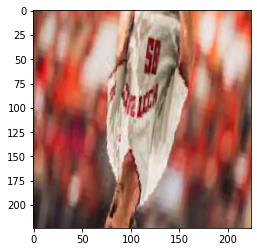

In [ ]:
for batch in val_set:
    x, y = batch
    plt.imshow(x[0])
    break

In [ ]:
te_set = test_datagen.flow_from_dataframe(test,
                                          x_col='file_path',
                                          y_col='place',
                                          target_size=(224, 224),
                                          classes=classes,
                                          class_mode='categorical',
                                          shuffle=False)

Found 1866 validated image filenames belonging to 18 classes.


## Model setting

In [ ]:
# import base model
base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
# add layers on top
x = base_model.output
x = layers.Flatten()(x)
x = layers.Dense(512, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dense(18, activation='relu')(x)

model = Model(inputs=base_model.inputs, outputs=x)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

In [ ]:
def visualize_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
 
    epochs = range(len(acc))

    plt.plot(epochs, acc, 'b', label='Training acc')
    plt.plot(epochs, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

In [ ]:
# Freeze some layers
for layer in model.layers[:-30]:
  layer.trainable = False

for i, layer in enumerate(model.layers):
    if layer.trainable:
        print(i, layer, layer.trainable)

61 <keras.layers.convolutional.DepthwiseConv2D object at 0x7fcd7c2d16d0> True
62 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fcd7c25b7d0> True
63 <keras.layers.advanced_activations.ReLU object at 0x7fcd7c2664d0> True
64 <keras.layers.convolutional.Conv2D object at 0x7fcd7c25bbd0> True
65 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fcd7c26ea10> True
66 <keras.layers.advanced_activations.ReLU object at 0x7fcd7c274e90> True
67 <keras.layers.convolutional.DepthwiseConv2D object at 0x7fcd7c2787d0> True
68 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fcd7c282910> True
69 <keras.layers.advanced_activations.ReLU object at 0x7fcd7c28fd90> True
70 <keras.layers.convolutional.Conv2D object at 0x7fcd7c28b5d0> True
71 <keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7fcd7c290b10> True
72 <keras.layers.advanced_activations.ReLU object at 0x7fcd7c218f50> True
73 <ke

In [ ]:
tr_step = tr_set.samples//tr_set.batch_size
val_step = val_set.samples//val_set.batch_size

In [ ]:
# set the hyperparameters : learning rate, number of epochs
lr = 1e-5
n_epochs = 50

In [ ]:
lr_scheduler = ExponentialDecay(
    initial_learning_rate=lr,
    decay_steps=10000,
    decay_rate=0.9
)

In [ ]:
# compile the model
model.compile(optimizer=Adam(learning_rate=lr_scheduler),
              loss='categorical_crossentropy',
              metrics=['accuracy'],
              )

In [ ]:
# training the model with train dataset and validating 
history = model.fit(tr_set,
                    steps_per_epoch=tr_step,
                    epochs=n_epochs,
                    validation_data=val_set,
                    validation_steps=val_step,
                    verbose = 1
                    )

Epoch 1/50
93/93 [==============================] - 1760s 19s/step - loss: 5.7426 - accuracy: 0.1374 - val_loss: 3.3151 - val_accuracy: 0.2418
Epoch 2/50
93/93 [==============================] - 640s 7s/step - loss: 3.2577 - accuracy: 0.1856 - val_loss: 2.6001 - val_accuracy: 0.2514
Epoch 3/50
93/93 [==============================] - 638s 7s/step - loss: 2.8184 - accuracy: 0.2341 - val_loss: 2.4802 - val_accuracy: 0.2969
Epoch 4/50
93/93 [==============================] - 638s 7s/step - loss: 2.7611 - accuracy: 0.2473 - val_loss: 2.4144 - val_accuracy: 0.3166
Epoch 5/50
93/93 [==============================] - 637s 7s/step - loss: 2.6121 - accuracy: 0.2773 - val_loss: 2.3751 - val_accuracy: 0.3675
Epoch 6/50
93/93 [==============================] - 642s 7s/step - loss: 2.5588 - accuracy: 0.3101 - val_loss: 2.3133 - val_accuracy: 0.3784
Epoch 7/50
93/93 [==============================] - 640s 7s/step - loss: 2.5867 - accuracy: 0.3286 - val_loss: 2.2245 - val_accuracy: 0.4124
Epoch 8/50


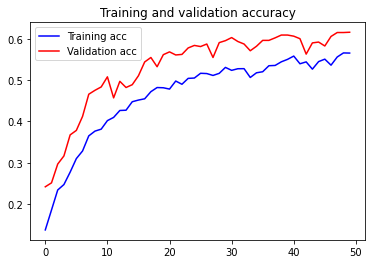

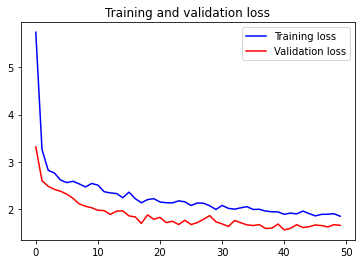

In [ ]:
# plot the result 
visualize_results(history)

## Predict

In [ ]:
te_loss, te_accuracy = model.evaluate(te_set)

59/59 [==============================] - 380s 6s/step - loss: 1.3856 - accuracy: 0.6624




*   18layers / lr = 1e-5 / epochs = 30 : val acc : 0.56 / te acc : 0.62
*   30layers / lr = 1e-5 / epochs = 100 : val acc : / te acc : 0.66


In [ ]:
# save trained model
model.save(f'Models/MobileNet_layer30+lr{lr}+epochs{n_epochs}')

INFO:tensorflow:Assets written to: Models/MobileNet_layer30+lr1e-05+epochs50/assets


In [ ]:
# predict from test dataset
predictions = model.predict(te_set)

In [ ]:
# label dictionary
labels = (tr_set.class_indices)
labels = dict((v , k) for k , v in labels.items())
print(labels)

In [ ]:
# getiing predicted label 
pred = np.argmax(predictions, axis=1)
predicted_place = [labels[i] for i in pred]

In [ ]:
# compare predicted label with the original label
test['prediction'] = predicted_place
len(test[test['place'] == test['prediction']])